In [3]:
import os
import pandas

mirna_src_dir = os.getcwd() + "/assn-mirna-luad/data/processed/miRNA/"
clinical_src_dir = os.getcwd() + "/assn-mirna-luad/data/processed/clinical/"

mirna_tumor_df = pandas.read_csv(mirna_src_dir+'tumor_miRNA.csv')
mirna_normal_df = pandas.read_csv(mirna_src_dir+'normal_miRNA.csv')
clinical_df = pandas.read_csv(clinical_src_dir+'clinical.csv')

print "mirna_tumor_df.shape", mirna_tumor_df.shape
print "mirna_normal_df.shape", mirna_normal_df.shape

"""
Here we select samples to use for our regression analysis
"""
matched_samples = pandas.merge(clinical_df, mirna_normal_df, on='patient_barcode')['patient_barcode']
print "matched_samples", matched_samples.shape
# merged = pandas.merge(clinical_df, mirna_normal_df, on='patient_barcode')
# print merged.shape
# print
# print merged['histological_type'].value_counts().sort_index(axis=0)
# print
# print merged['pathologic_stage'].value_counts().sort_index(axis=0)
# print
# print merged['pathologic_T'].value_counts().sort_index(axis=0)
# print
# print merged['pathologic_N'].value_counts().sort_index(axis=0)
# print
# print merged['pathologic_M'].value_counts().sort_index(axis=0)
# print

mirna_tumor_df.shape (513, 1882)
mirna_normal_df.shape (46, 1882)
matched_samples (46,)


## We now create data matrixes from tumor vs normal samples

In [25]:
from sklearn import preprocessing
import numpy as np
X_normal = mirna_normal_df[mirna_normal_df['patient_barcode'].isin(matched_samples)]
X_tumor = mirna_tumor_df[mirna_tumor_df['patient_barcode'].isin(matched_samples)]
X_normal.__delitem__('patient_barcode')
X_tumor.__delitem__('patient_barcode')

X = pandas.concat([X_normal, X_tumor])
# Create labels for 92 samples, first 46 labeled 0 indicating normal tissues, and last 46 labeled 1 for tumor tissues
Y = np.concatenate((np.zeros(46), np.ones(46)), axis=0)

# print 'miRNA null values', X.isnull().sum().sum()
# print 'Y null values', Y.isnull().sum()

print "X_normal.shape", X_normal.shape
print "X_tumor.shape", X_tumor.shape
print "Y.shape", Y.shape

mirna_list = X.columns.values
# 
X_scaler = preprocessing.StandardScaler(with_mean=False).fit(X)
X = X_scaler.transform(X)

X_normal.shape (46, 1881)
X_tumor.shape (46, 1881)
Y.shape (92,)


AttributeError: 'numpy.ndarray' object has no attribute 'describe'

## Perform classification with an L1-regularized Logistic Regression

In [31]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=np.random.randint(0, 10000))
print 'X_train', X_train.shape, ', y_train', y_train.shape
print 'X_test', X_test.shape, ', y_test', y_test.shape

model = linear_model.LogisticRegressionCV(penalty="l1", fit_intercept=False, verbose=3)
print model.fit(X_train, y_train)

print "\nNon-zero coef:", np.nonzero(model.coef_.ravel())[0].size
print "miRNA's selected:\n", mirna_list[np.nonzero(model.coef_.ravel())[0]]
print "miRNA's corresponding coefficients:\n", model.coef_.ravel()[np.nonzero(model.coef_.ravel())[0]]

print "\nClassification_report on training"
print metrics.classification_report(y_train, model.predict(X_train), labels=[0, 1], target_names=["normal", "tumor"])
print "classification_report on testing"
print metrics.classification_report(y_test, model.predict(X_test), labels=[0, 1], target_names=["normal", "tumor"])
print metrics.confusion_matrix(y_test, model.predict(X_test), labels=[0, 1])

X_train (73, 1881) , y_train (73,)
X_test (19, 1881) , y_test (19,)
[LibLinear]LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=3, warm_start=False)

Non-zero coef: 35
miRNA's selected:
['hsa-mir-1-1' 'hsa-mir-133a-1' 'hsa-mir-139' 'hsa-mir-183' 'hsa-mir-21'
 'hsa-mir-218-1' 'hsa-mir-218-2' 'hsa-mir-30a' 'hsa-mir-3140'
 'hsa-mir-3194' 'hsa-mir-4424' 'hsa-mir-4429' 'hsa-mir-4442' 'hsa-mir-4491'
 'hsa-mir-4494' 'hsa-mir-4664' 'hsa-mir-4703' 'hsa-mir-4774' 'hsa-mir-4777'
 'hsa-mir-4791' 'hsa-mir-486-1' 'hsa-mir-486-2' 'hsa-mir-510' 'hsa-mir-598'
 'hsa-mir-625' 'hsa-mir-639' 'hsa-mir-6787' 'hsa-mir-6825' 'hsa-mir-6892'
 'hsa-mir-708' 'hsa-mir-7-1' 'hsa-mir-7108' 'hsa-mir-7-2' 'hsa-mir-7974'
 'hsa-mir-96']
miRNA's corresponding coefficients:
[ -3.44299096e-01  -5.68782432e-01  -3.14588704e-01   5.9

In [28]:
print y_test
print np.inner(model.coef_, X_test)

[ 1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.  1.
  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  1.  1.
  0.]
[[ 1.55804261 -4.79624458 -2.04044484  3.32600288 -0.39007657 -5.61536437
  -2.4036498   1.11931394 -2.90935806  6.40865992  2.32315147 -1.33395425
  -1.22692124  2.24597539 -0.74993258  0.29071045  0.58042265  3.95923168
  -1.16513456 -2.42192391 -2.91734918  3.7828611  -2.3107312  -3.38119279
  -2.49554981  2.34035526 -4.36734674 -2.28418265 -2.29993133 -3.0727912
   2.39905012 -0.99906855  2.5182848  -5.57541398  3.44387051  1.44978903
  -1.15006228]]


array([ 0.1474463 ,  0.07509905,  0.15177167, ...,  0.42225197,
        0.7850748 ,  0.8493413 ])

In [15]:
print "classification_report on rest of tumor patients"
X_tumor_unmatched = mirna_tumor_df.dropna(subset=['hsa-mir-96']).copy()
X_tumor_unmatched.__delitem__('patient_barcode')
X_tumor_unmatched = X_scaler.transform(X_tumor_unmatched)
print X_tumor_unmatched.shape

Y_tumor_unmatched = np.array([1,]*X_tumor_unmatched.shape[0], dtype=int)

print metrics.classification_report(Y_tumor_unmatched, model.predict(X_tumor_unmatched), labels=[0, 1], target_names=["normal", "target"])
print metrics.confusion_matrix(Y_tumor_unmatched, model.predict(X_tumor_unmatched), labels=[0, 1])

classification_report on rest of tumor patients
(513, 1881)
             precision    recall  f1-score   support

     normal       0.00      0.00      0.00         0
     target       1.00      0.95      0.97       513

avg / total       1.00      0.95      0.97       513

[[  0   0]
 [ 28 485]]


Try to draw a LASSO path

In [53]:
from sklearn.linear_model import lasso_path
from itertools import cycle

eps = 5e-3  # the smaller it is the longer is the path

alphas_lasso, coefs_lasso, _ = lasso_path(X, Y, eps, fit_intercept=False)

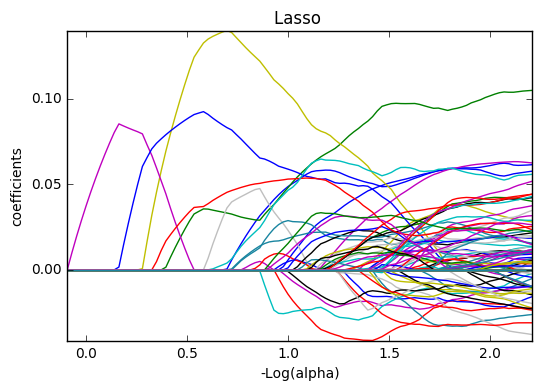

In [54]:
from matplotlib import pyplot as plt

colors = cycle(['r', 'b', 'g', 'c', 'k', 'm', 'y', '0.75', '#1985a0'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)

for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso ')
plt.axis('tight')
plt.show()